In [1]:
import os

os.chdir(globals()["_dh"][0])
print("Current working directory:", os.getcwd())
os.chdir('/home/mohammad.hallaq/workarea/MobileNet_compression') # change accordingly

Current working directory: /home/mohammad.hallaq


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torch_pruning as tp
from mobilenetv3 import mobilenetv3
from collections import defaultdict
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as L
import h5py
from torch.utils.data import Dataset
import copy
import torch.nn as nn 
from tqdm import tqdm
from torchinfo import summary
import csv
from torch.profiler import profile

In [3]:
# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [4]:
class R22_H5_Dataset(Dataset):
    def __init__(self, data_file, label='label', iqlabel='iq_data'):
        self.data_file = data_file
        self.label = label
        self.iqlabel = iqlabel

    def __len__(self):
        with h5py.File(self.data_file, 'r') as f:
            length = len(f[self.label])
        return length

    def __getitem__(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            iq_data = f[self.iqlabel][idx]
            label = f[self.label][idx]
        return iq_data, label
    
    def get_metadata(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            metadata = {
                'recording': f['recording'][idx].decode('utf-8)'),
                'category': f['category'][idx].decode('utf-8)')
            }
        return metadata


In [10]:
train_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/r22_train.h5'
val_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/r22_val.h5'
test_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/r22_test.h5'
checkpoint_dir = '/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints-Copy2'
checkpoint_filename = os.path.join(checkpoint_dir, 'august22_beam_t.ckpt')
checkpoint =torch.load(checkpoint_filename)

In [5]:
example_length = 4096
batch_size = 128
epochs =30

hparams = {
    'drop_path_rate': 0.2,
    'drop_rate': 0.7,
    'learning_rate': 1e-3,
    'wd': 0.01
}

In [11]:
train_data = '/shared/sepData_train.h5'
val_data = '/shared/sepData_val.h5'
test_data = '/shared/sepData_test.h5'

train_set = R22_H5_Dataset(train_data)
val_set = R22_H5_Dataset(val_data)
test_set = R22_H5_Dataset(test_data)
print(f'Training Set: {len(train_set)} examples')
print(f'Validation Set: {len(val_set)} examples')
print(f'Testing Set: {len(test_set)} examples')

num_classes = train_set[0][1].shape[0]

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=128,
    shuffle=False,
    num_workers=8
    )
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=128,
    shuffle=False,
    num_workers=8
    )

Training Set: 809836 examples
Validation Set: 223016 examples
Testing Set: 249368 examples


In [7]:
original_model = mobilenetv3(
    model_size='mobilenetv3_small_050',
    num_classes=num_classes,
    drop_rate=hparams['drop_rate'],
    drop_path_rate=hparams['drop_path_rate'],
    in_chans=8
)

# rf_classifier = RFClassifier.load_from_checkpoint(original_model_checkpoint, model=model)

# rf_classifier.to('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:
def remove_prefix_from_state_dict(state_dict, prefix='model.'):

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix):]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [13]:
checkpoint['state_dict'] = remove_prefix_from_state_dict(checkpoint['state_dict'], prefix='model.')

original_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Evaluating The Pruned Model

In [14]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/best_model(20011_parameters).pth')

In [12]:
def plot_quiver(all_targets, all_outputs, quiver_path: str):
    """
    Creates and stores the quiver plot for given targets and predicted outputs
    :args all_targets:
    :args all_outputs:
    """
    predictions_per_target = defaultdict(list)
    errors_per_target = dict()

    for idx, target_angles_tuple in enumerate(all_targets):
        target_tuple = tuple(target_angles_tuple)
        predictions_per_target[target_tuple].append(all_outputs[idx])
    for target_tuple, list_of_predictions in predictions_per_target.items():
        # predictions_per_target[target_tuple] = np.mean(list_of_predictions, axis=0)
        errors_per_target[target_tuple] = np.subtract(target_tuple, np.mean(list_of_predictions, axis=0))

    unique_targets = list(errors_per_target.keys())
    unique_azimuth = [target[0] for target in unique_targets]
    unique_elevation = [target[1] for target in unique_targets]
    unique_erros = list(errors_per_target.values())
    errors_azimuth = [target[0] for target in unique_erros]
    errors_elevation = [target[1] for target in unique_erros]

    plt.figure(figsize=(10, 10))
    plt.scatter(unique_azimuth, unique_elevation, color='red', label='True Angles')
    plt.quiver(unique_azimuth, unique_elevation, errors_azimuth, errors_elevation,
                angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Angles')
    plt.xlim([-55, 55])
    plt.ylim([-55, 55])
    plt.xlabel('Azimuth')
    plt.ylabel('Elevation')
    plt.grid()
    plt.legend()
    plt.savefig(quiver_path)

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1949/1949 [01:01<00:00, 31.58batch/s, Val Loss=2.13]


Test Set Loss = 0.0010929217872562955


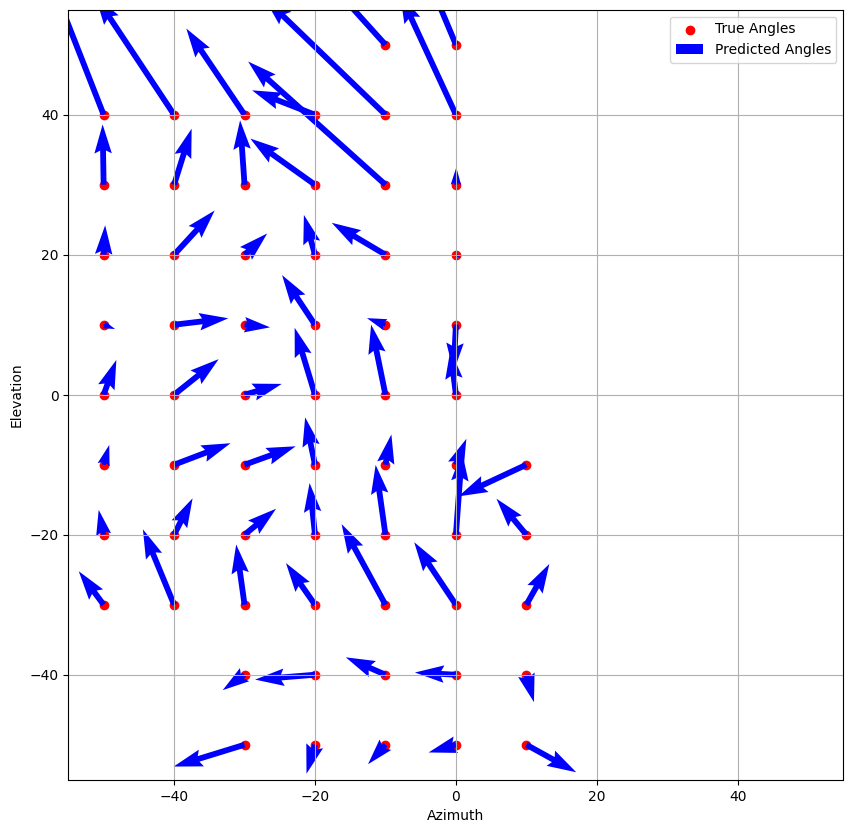

In [15]:
criterion = nn.MSELoss()
experiment_path = '/home/mohammad.hallaq/workarea/AoA-Pruning/experiments'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pruned_model = pruned_model.to(device)
pruned_model.eval()

test_loss, num_samples = 0, 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])
with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = pruned_model(sample_inputs)
            loss = criterion(outputs, targets)
            num_samples += targets.shape[0]
            test_loss += loss.item()/num_samples
            all_targets = np.concatenate((all_targets, targets.cpu()))
            all_outputs = np.concatenate((all_outputs, outputs.cpu()))
            pbar.set_postfix({'Val Loss': test_loss})
    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    test_loss = test_loss / len(test_loader)
    print(f"Test Set Loss = {test_loss}")
    quiver_path = os.path.join(experiment_path, "testing_quiver_plot.png")
    plot_quiver(all_targets, all_outputs, quiver_path)

In [10]:
def analyze_model_and_save_to_csv(model, val_loader, device=None, csv_file='model_analysis.csv', model_name=None):
  
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    first_batch = next(iter(val_loader))
    input_tensor, true_angles = first_batch
    input_tensor = input_tensor.to(device)


    model.to(device)
    example_inputs = input_tensor.to(device)
    print('This is the shape of the input: ', example_inputs.shape)
    

    analysis_results = {
        'model_name': model_name if model_name else model.__class__.__name__,
        'model_size_mb (MB)': None,
        'GFLOPs (GFLOPs)': None,
        'Total_Params (count)': None,
        'First_Forward_Pass_Time (s)': None,
        'Training_Time (s)': None,
        'Inference_Time (s)': None,
        'CUDA_Time (ms)': None,
        'CPU_Time (ms)': None,
        'mse': None,
        'mae': None
    }
    
 
    try:
        model.to(device)
        example_inputs = example_inputs.to(device)
    
 
        flops, params = tp.utils.count_ops_and_params(model, example_inputs)
        analysis_results['GFLOPs (GFLOPs)'] = flops  
        analysis_results['Total_Params (count)'] = params

    except Exception:
        pass 


    try:
        torch.save(model.state_dict(), "temp.pth")
        model_size = os.path.getsize("temp.pth") / (1024 * 1024)  # Convert to MB
        os.remove("temp.pth")
        analysis_results['model_size_mb (MB)'] = model_size
    except Exception:
        pass


    try:
        model.eval()
        with torch.no_grad():
            start_time = time.time()
            _ = model(example_inputs)
            end_time = time.time()
        analysis_results['First_Forward_Pass_Time (s)'] = end_time - start_time
    except Exception:
        pass

    try:
        # Create CUDA events to measure time
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        iterations = 1000 # Number of iterations within each test
        num_tests = 20 # Number of times to run the inference test
        total_time = 0.0
        
        for test in range(num_tests):
            # Record the start time
            start_event.record()
            for _ in range(iterations):
                with torch.no_grad():
                    _ = model(example_inputs)
            end_event.record()
            torch.cuda.synchronize()
            iteration_time = start_event.elapsed_time(end_event)/iterations
            total_time += iteration_time
        
        average_inference_time = total_time / num_tests
        
        analysis_results['Inference_Time (ms)'] = average_inference_time
    except Exception:
        pass


    try:
        model.eval()
        with torch.no_grad():
            if torch.cuda.is_available():
                torch.cuda.synchronize()  
                with profile(use_cuda=True) as prof:
                    _ = model(example_inputs)
                # Collect CUDA times
                cuda_time_total = sum(evt.cuda_time for evt in prof.key_averages())
                cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
                analysis_results['CUDA_Time (ms)'] = cuda_time_total / 1e3
                analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
            else:
                with profile(use_cuda=False) as prof:
                    _ = model(example_inputs)
                # Collect CPU times only
                cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
                analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
    except Exception as e:
        print(f"Error during profiling: {e}")
        pass

    try:
        model.eval()
        y_preds = []
        y_true = []
        with torch.inference_mode():
            for sample in val_loader:
                data, target = sample[0].to(device), sample[1].to(device)
                y_true += target.tolist()
                output = model(data)
                y_preds += output.cpu().tolist()

        y_true = np.array(y_true)
        y_preds = np.array(y_preds)


        mse = np.square(y_true - y_preds).mean()
        mae = np.absolute(y_true - y_preds).mean()

        analysis_results['mse'] = mse
        analysis_results['mae'] = mae
    except Exception:
        pass
    

    file_exists = os.path.isfile(csv_file)
    
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=analysis_results.keys())
        
        if not file_exists:
            writer.writeheader()  
        
        writer.writerow(analysis_results)  

    return analysis_results

In [11]:
# Set seed for reproducibility
torch.manual_seed(42)

# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

# example_inputs = torch.randn(128, 1, 8, 4096)  

results = analyze_model_and_save_to_csv(original_model, test_loader, device=None, csv_file='model_analysis.csv')


This is the shape of the input:  torch.Size([128, 8, 4096])


/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/torch/profiler/profiler.py:599: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2024-09-28 00:42:02 2529265:2529265 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-09-28 00:42:02 2529265:2529265 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-28 00:42:02 2529265:2529265 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [13]:
results

{'model_name': 'MobileNetV3',
 'model_size_mb (MB)': 0.16710662841796875,
 'GFLOPs (GFLOPs)': 4221640.0,
 'Total_Params (count)': 20011,
 'First_Forward_Pass_Time (s)': 0.007390260696411133,
 'Training_Time (s)': None,
 'Inference_Time (s)': 0.006533912217617036,
 'CUDA_Time (ms)': 1.2917417988813895,
 'CPU_Time (ms)': 44.367,
 'mse': 11.072968327240007,
 'mae': 2.1413888255779048}

In [13]:
results

{'model_name': 'MobileNetV3',
 'model_size_mb (MB)': 0.16710662841796875,
 'GFLOPs (GFLOPs)': 4221640.0,
 'Total_Params (count)': 20011,
 'First_Forward_Pass_Time (s)': 0.00914311408996582,
 'Training_Time (s)': None,
 'Inference_Time (s)': 6.526299609375,
 'CUDA_Time (ms)': 1.2900709757295232,
 'CPU_Time (ms)': 46.39,
 'mse': 11.072968327240007,
 'mae': 2.1413888255779048}

In [12]:
results

{'model_name': 'MobileNetV3',
 'model_size_mb (MB)': 2.1934127807617188,
 'GFLOPs (GFLOPs)': 23439648.0,
 'Total_Params (count)': 548482,
 'First_Forward_Pass_Time (s)': 0.17281579971313477,
 'Training_Time (s)': None,
 'Inference_Time (s)': None,
 'CUDA_Time (ms)': 0.0,
 'CPU_Time (ms)': 258.884,
 'mse': 1.2235901073928497,
 'mae': 0.5767371606355566,
 'Inference_Time (ms)': 171.6847984375}

: 

In [13]:
results

{'model_name': 'MobileNetV3',
 'model_size_mb (MB)': 2.1971359252929688,
 'GFLOPs (GFLOPs)': 23439648.0,
 'Total_Params (count)': 548482,
 'First_Forward_Pass_Time (s)': 0.007468700408935547,
 'Training_Time (s)': None,
 'Inference_Time (s)': 15.769742529296874,
 'CUDA_Time (ms)': 3.291604980120744,
 'CPU_Time (ms)': 49.332,
 'mse': 1.2235874766855361,
 'mae': 0.576736716231774}

In [10]:
import torch
import time

def measure_inference_time(model, validation_loader, device="cuda", num_iterations=100):
    model.eval()
    model.to(device)
    
    # Create CUDA events to measure time
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
    total_time = 0.0
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(validation_loader):
            if i >= num_iterations:  # Limit the number of iterations
                break
            
            inputs = inputs.to(device)
            
            # Record the start time
            start_event.record()
            
            # Forward pass
            _ = model(inputs)
            
            # Record the end time
            end_event.record()
            
            # Wait for everything to finish
            torch.cuda.synchronize()
            
            # Measure time
            iteration_time = start_event.elapsed_time(end_event)  # Time in milliseconds
            total_time += iteration_time
    
    avg_time_per_batch = total_time / num_iterations
    print(f"Average inference time per batch: {avg_time_per_batch:.4f} ms")
    return avg_time_per_batch


In [12]:
inf_time = measure_inference_time(original_model, val_loader)

Average inference time per batch: 16.2666 ms


In [20]:
# Define input shape
input_size = (1, 8, 4096)  # For MNIST-like input

# Capture summary into a string and write to file
with open("model_structure.txt", "w") as f:
    summary_string = summary(pruned_model, input_size=input_size, verbose=0)
    f.write(str(summary_string))

In [30]:
def calculate_average_deviation(loader, model):
    device = next(model.parameters()).device
    model.to(device)
    total_azimuth_deviation = 0
    total_elevation_deviation = 0
    num_samples = 0
    with torch.no_grad():
        for batch in loader:
            inputs, true_angles = batch
            inputs, true_angles = inputs.to(device), true_angles.to(device)
            predicted = model(inputs).cpu().numpy()
            true_angles = true_angles.cpu().numpy()
            azimuth_deviation = np.abs(predicted[:, 0] - true_angles[:, 0])
            elevation_deviation = np.abs(predicted[:, 1] - true_angles[:, 1])
        
            total_azimuth_deviation += np.sum(azimuth_deviation)
            total_elevation_deviation += np.sum(elevation_deviation)
            num_samples += len(true_angles)
    avg_azimuth_deviation = total_azimuth_deviation / num_samples
    avg_elevation_deviation = total_elevation_deviation / num_samples
    return avg_azimuth_deviation, avg_elevation_deviation

In [31]:
avg_azim_dev, avg_elev_dev = calculate_average_deviation(val_loader, pruned_model)
print(avg_azim_dev, avg_elev_dev)

2.0799208594635883 2.202856791666683


In [15]:
def measure_inference_time(model: torch.nn.Module, validation_loader: torch.utils.data.DataLoader, num_tests: int = 5, num_iterations: int = 5) -> None:
    """
    Measure the inference time of a PyTorch model on a CPU for multiple tests and iterations.

    Args:
        model (torch.nn.Module): The PyTorch model.
        validation_loader (torch.utils.data.DataLoader): The DataLoader for the validation dataset.
        num_tests (int): The number of tests to run the inference.
        num_iterations (int): The number of iterations to run the inference for each test.

    Returns:
        None: Prints the total and average inference time for each test and overall statistics.
    """
    # Move the model to CPU and set it to evaluation mode
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    # Disable gradient calculations for inference
    overall_total_time = 0.0

    with torch.no_grad():
        for test in range(num_tests):
            print(f"Running Test {test + 1}/{num_tests}")
            test_total_time = 0.0

            for iteration in range(num_iterations):
                print(f"  Iteration {iteration + 1}/{num_iterations}")
                iteration_inference_time = 0.0

                for batch in validation_loader:
                    # Move the batch to the CPU (if tensors are not already on CPU)
                    batch = [tensor.to(device) for tensor in batch]

                    # Start timing
                    start_time = time.time()

                    # Perform inference
                    inputs = batch[0]  # Assuming the first element in the batch is the input tensor
                    _ = model(inputs)

                    # End timing
                    batch_inference_time = time.time() - start_time
                    iteration_inference_time += batch_inference_time

                # Add the inference time for this iteration to the total for the test
                test_total_time += iteration_inference_time
                print(f"    Inference time for iteration {iteration + 1}: {iteration_inference_time:.4f} seconds")

            # Calculate and print the average inference time per batch for this test
            avg_test_time = test_total_time / (len(validation_loader) * num_iterations)
            overall_total_time += test_total_time

            print(f"Total inference time for Test {test + 1}: {test_total_time:.4f} seconds")
            print(f"Average inference time per batch for Test {test + 1}: {avg_test_time:.4f} seconds\n")

    # Calculate and print overall statistics
    overall_avg_time = overall_total_time / (num_tests * len(validation_loader) * num_iterations)
    print(f"Overall total inference time for {num_tests} tests: {overall_total_time:.4f} seconds")
    print(f"Overall average inference time per batch: {overall_avg_time:.4f} seconds")

# Example usage
# avg_time = measure_inference_time(model, validation_loader, num_tests=3, num_iterations=10)

In [19]:
# Measure the inference time on CPU
avg_time = measure_inference_time(original_model, test_loader)

Running Test 1/5
  Iteration 1/5
    Inference time for iteration 1: 359.6289 seconds
  Iteration 2/5
    Inference time for iteration 2: 363.6037 seconds
  Iteration 3/5
    Inference time for iteration 3: 359.1997 seconds
  Iteration 4/5
    Inference time for iteration 4: 356.5188 seconds
  Iteration 5/5
    Inference time for iteration 5: 359.2721 seconds
Total inference time for Test 1: 1798.2232 seconds
Average inference time per batch for Test 1: 0.1845 seconds

Running Test 2/5
  Iteration 1/5
    Inference time for iteration 1: 348.4467 seconds
  Iteration 2/5
    Inference time for iteration 2: 345.9154 seconds
  Iteration 3/5
    Inference time for iteration 3: 325.8452 seconds
  Iteration 4/5
    Inference time for iteration 4: 316.4147 seconds
  Iteration 5/5
    Inference time for iteration 5: 312.7913 seconds
Total inference time for Test 2: 1649.4133 seconds
Average inference time per batch for Test 2: 0.1693 seconds

Running Test 3/5
  Iteration 1/5
    Inference time 

RuntimeError: DataLoader worker (pid 26043) is killed by signal: Terminated. 

In [16]:
# Measure the inference time on CPU
avg_time = measure_inference_time(pruned_model, test_loader)

Running Test 1/5
  Iteration 1/5
    Inference time for iteration 1: 88.6430 seconds
  Iteration 2/5
    Inference time for iteration 2: 93.6028 seconds
  Iteration 3/5
    Inference time for iteration 3: 94.0650 seconds
  Iteration 4/5
    Inference time for iteration 4: 91.3547 seconds
  Iteration 5/5
    Inference time for iteration 5: 94.3829 seconds
Total inference time for Test 1: 462.0484 seconds
Average inference time per batch for Test 1: 0.0474 seconds

Running Test 2/5
  Iteration 1/5
    Inference time for iteration 1: 109.8235 seconds
  Iteration 2/5
    Inference time for iteration 2: 91.4578 seconds
  Iteration 3/5
    Inference time for iteration 3: 90.6454 seconds
  Iteration 4/5
    Inference time for iteration 4: 103.5278 seconds
  Iteration 5/5
    Inference time for iteration 5: 106.0151 seconds
Total inference time for Test 2: 501.4695 seconds
Average inference time per batch for Test 2: 0.0515 seconds

Running Test 3/5
  Iteration 1/5
    Inference time for itera

In [17]:
sample = next(iter(test_loader))
base_macs, base_nparams = tp.utils.count_ops_and_params(original_model, sample[0])
macs, nparams = tp.utils.count_ops_and_params(pruned_model, sample[0])
print(f"MACs: {base_macs/1e9} G -> {macs/1e9} G, #Params: {base_nparams/1e6} M -> {nparams/1e6} M")

MACs: 0.023439648 G -> 0.00422164 G, #Params: 0.548482 M -> 0.020011 M
